<a href="https://colab.research.google.com/github/Kennycen/Ad-Campaign-Project/blob/main/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ad Campaign Group Project

## 👥 Team Members
- Kenny Cen, Shaad Patankar, Chi Zhao, Aisharwya Khadka, Sedode Avoseh

## Step 0: Setup
- Import Libraries (pandas, numpy, random, datetime, matplotlib, seaborn)

In [1]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import json
from faker import Faker
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Data
- 1,000 users, 60% female, 2 to 8 campaigns per user

In [3]:
# initialize the Faker generator
fake = Faker()
Faker.seed(0)  # Seed for reproducible fake data
random.seed(0)  # Seed for reproducible random numbers

# Define total users and female ratio
NUM_USERS = 1000
FEMALE_RATIO = 0.6
NUM_FEMALES = int(NUM_USERS * FEMALE_RATIO)  # Calculate how many should be female (60%)

# Function to generate a fake user based on gender
def generate_user(gender):
    if gender == 'F':
        name = fake.name_female()  # Generate a female name
    else: name = fake.name_male()  # Generate a male name

    return {
        "name": name,
        "username": fake.user_name(),  # Generate a random username
        "gender": gender,
        "age": random.randint(18, 60), # Random age between 18 and 60
        "email": fake.email(),         # Random email
        "address": fake.address().replace("\n", ", ") # Random address (cleaned up)
    }

users = []  # List to hold all generated users
female_count = 0   # Counter to track how many female users have been added
for _ in range(NUM_USERS):
    if female_count < NUM_FEMALES:
        gender = 'F'  # Assign female until the target is reached 60%
        female_count += 1
    else:
        gender = 'M'  # Remaining users will be male

    user = generate_user(gender)  # Create user
    users.append(user)  # Add to the users list

In [4]:
# Function to generate a fake ad campaign for a user
def generate_campaign(user):
    start_date = fake.date_between(start_date='-3y', end_date='-1y') # Random start date between 1-3 years ago
    duration = random.randint(7, 180)  # Campaign last between 1 week to 6 months
    end_date = start_date + timedelta(days=duration)  # Calculate end date

    age_start = random.choice(range(18, 50, 5))
    age_end = random.choice(range(25, 65, 5))
    age_group = f"{age_start}-{age_end}"  # Combine to form string like "25-50"

    gender_target = user["gender"]  # Target gender same as user gender
    currency = "USD"  # All budgets in USD

    impressions = random.randint(1000, 100000)  # Total ad views
    clicks = random.randint(1, impressions)  # Clicks can't exceed impressions
    spent = round(random.uniform(100, 50000), 2)  # Random amount spent
    budget = round(spent * random.uniform(1.1, 2.0), 2)  # Budget is 10-100% more than spent

    return {
        "name": f"CPC_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}_{age_group}_{gender_target}_{currency}",
        "budget": budget,
        "spent": spent,
        "impressions": impressions,
        "clicks": clicks
    }

# Generate campaigns for each user
user_campaign_data = []

for user in users:
    num_campaigns = random.randint(2, 8)  # Each user has between 2 and 8 campaigns
    campaigns = []  # Temporary list to store this user's campaigns

    for _ in range(num_campaigns):  # Standard loop to generate campaigns
        campaign = generate_campaign(user)
        campaigns.append(campaign)

    user_campaign_data.append({     # Combine user info with their campaigns and store it
        "user": user,
        "campaigns": campaigns
    })

# Step 2: Clean and denormalize Data

In [5]:
# Flatten into desired structure for slide
flattened_for_df = []

for entry in user_campaign_data:
    user = entry["user"]
    user_str = json.dumps(user)  # convert to string (JSON)

    for campaign in entry["campaigns"]:
        flattened_for_df.append({
            "cmp_bgt": campaign["budget"],
            "cmp_clicks": campaign["clicks"],
            "cmp_impr": campaign["impressions"],
            "cmp_name": campaign["name"],
            "cmp_spent": campaign["spent"],
            "user": user_str
        })

df = pd.DataFrame(flattened_for_df)

df.head()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,29384.95,19748,33935,CPC_20220708_20220901_48-40_F_USD,15680.38,"{""name"": ""Norma Fisher"", ""username"": ""tammy76""..."
1,4503.91,31453,94386,CPC_20230524_20230804_33-50_F_USD,2320.69,"{""name"": ""Norma Fisher"", ""username"": ""tammy76""..."
2,4513.00,57436,65920,CPC_20230326_20230420_18-60_F_USD,2468.68,"{""name"": ""Norma Fisher"", ""username"": ""tammy76""..."
3,4952.42,2806,16482,CPC_20240316_20240727_33-60_F_USD,4165.70,"{""name"": ""Norma Fisher"", ""username"": ""tammy76""..."
4,5861.94,40158,58755,CPC_20221227_20230211_33-40_F_USD,3949.45,"{""name"": ""Kelly Brown"", ""username"": ""davismary..."


# Step 3: Manipulate the Data

### Unpack Campaign Name

In [6]:
def unpack_cmp_name(cmp_name):
    parts = cmp_name.split("_")
    return pd.Series({
        "Type": parts[0],
        "Start": datetime.strptime(parts[1], "%Y%m%d").strftime("%Y-%m-%d"),
        "End": datetime.strptime(parts[2], "%Y%m%d").strftime("%Y-%m-%d"),
        "Age": parts[3],
        "Gender": parts[4],
        "Currency": parts[5]
    })

# Apply to DataFrame and create new columns
unpacked_df = df["cmp_name"].apply(unpack_cmp_name)

df = df.join(unpacked_df)

# Display result like the table in the slide
unpacked_df.head()

,Type,Start,End,Age,Gender,Currency
0,CPC,2022-07-08,2022-09-01,48-40,F,USD
1,CPC,2023-05-24,2023-08-04,33-50,F,USD
2,CPC,2023-03-26,2023-04-20,18-60,F,USD
3,CPC,2024-03-16,2024-07-27,33-60,F,USD
4,CPC,2022-12-27,2023-02-11,33-40,F,USD


### Unpack User Data

In [7]:
# Apply unpacking using .apply and return Series
user_info = df["user"].apply(lambda u: pd.Series(json.loads(u)))

# Rename columns to match the slide example
user_info = user_info[["username", "email", "name", "gender", "age", "address"]]

# Join with the original DataFrame (optional)
df = df.join(user_info)

# Display the user data only (like the slide)
user_info.head()

,username,email,name,gender,age,address
0,tammy76,tammy59@example.org,Norma Fisher,F,42,"19489 Kyle Stream Apt. 578, West Ryanborough, ..."
1,tammy76,tammy59@example.org,Norma Fisher,F,42,"19489 Kyle Stream Apt. 578, West Ryanborough, ..."
2,tammy76,tammy59@example.org,Norma Fisher,F,42,"19489 Kyle Stream Apt. 578, West Ryanborough, ..."
3,tammy76,tammy59@example.org,Norma Fisher,F,42,"19489 Kyle Stream Apt. 578, West Ryanborough, ..."
4,davismary,salazarmaria@example.com,Kelly Brown,F,44,"139 John Divide Suite 115, Rodriguezside, LA 9..."


### Calculate New Columns

In [8]:
df["CTR"] = df["cmp_clicks"] / df["cmp_impr"]
df["CPC"] = df["cmp_spent"] / df["cmp_clicks"]
df["CPI"] = df["cmp_spent"] / df["cmp_impr"]

### More New Columns

In [9]:
# Convert 'Start' and 'End' to datetime
df["Start"] = pd.to_datetime(df["Start"], format="%Y-%m-%d")
df["End"] = pd.to_datetime(df["End"], format="%Y-%m-%d")

# Setting age range labels
age_bins = [18, 25, 35, 45, 55, 65]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55+']

# Add new columns
df["start_day"] = df["Start"].dt.day_name()
df["start_day"] = pd.Categorical(df["start_day"], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Create the new 'age_group' column using np.digitize and indexing
filtered_df = df[(df['age'] >= 18) & (df['age'] <= 65)]
df['age_group'] = np.array(age_labels)[np.digitize(filtered_df['age'], bins=age_bins, right=False) - 1]
df['age_group'] = pd.Categorical(df['age_group'], categories=age_labels, ordered=True)

df["campaign_duration_days"] = (df["End"] - df["Start"]).dt.days

# step 4: Save Dataframe to JSON format

In [10]:
df.to_json("cleaned_campaign_data.json", orient="records", indent=2)

# Step 5: Visualize, Explore. Aggregate.
- Where have we spent 75% of the budget?
- Break down by day of the week
- Analyze by target age group
- Visualize impressions, clicks, budget, and spent

In [11]:
sns.set(style='whitegrid')

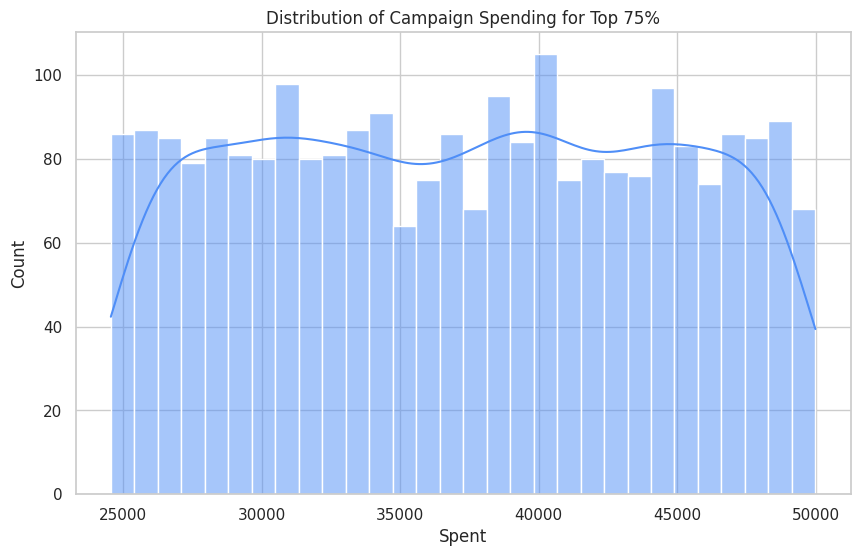

In [12]:
# Sort campaigns by spent, descending
df_sorted = df.sort_values("cmp_spent", ascending=False)

# Cumulate the cumulative sum of campaign spending
df_sorted["cumulative_spent"] = df_sorted["cmp_spent"].cumsum()

# Calculate the total amount spent across all campaigns
total_spent = df["cmp_spent"].sum()

# Compute the cumulative percentage of total spend for each campaign
df_sorted["cumulative_spent_pct"] = df_sorted["cumulative_spent"] / total_spent

# Filter the top 75% of campaigns based on cumulative spend
# These are the campaigns contributing to 75% of total spending
top_75 = df_sorted[df_sorted["cumulative_spent_pct"] <= 0.75]

# Plot the distribution of spending among top 75% campaigns
plt.figure(figsize=(10, 6)) # Set the size of the plot
sns.histplot(top_75["cmp_spent"], bins=30, kde=True, color="#4F8EF7")
plt.title("Distribution of Campaign Spending for Top 75%") # Title
plt.xlabel("Spent")
plt.ylabel("Count")
plt.show()

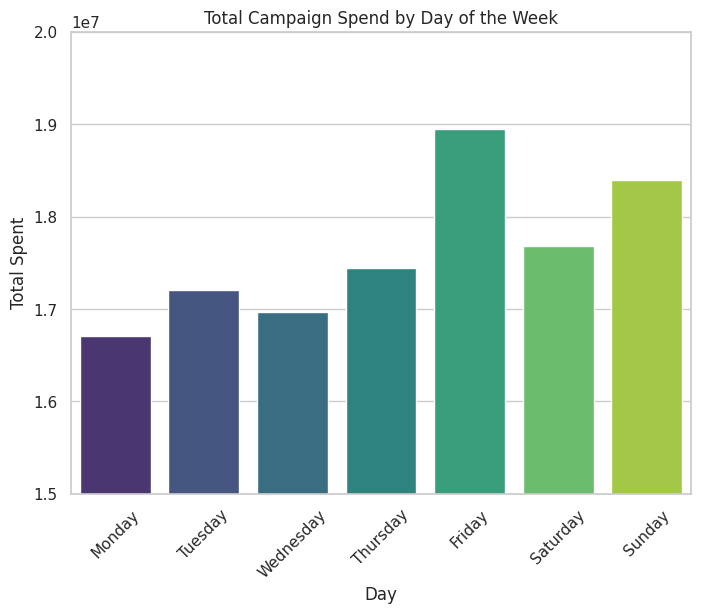

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="start_day", y="cmp_spent", estimator=sum, errorbar=None, hue="start_day", palette="viridis", dodge=False, legend=False) # ci is deprecated instead used 'errorbar'
plt.title("Total Campaign Spend by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Total Spent")
plt.xticks(rotation=45)
plt.ylim(15000000,20000000) #take a y range so we can better see differences between days
plt.show()

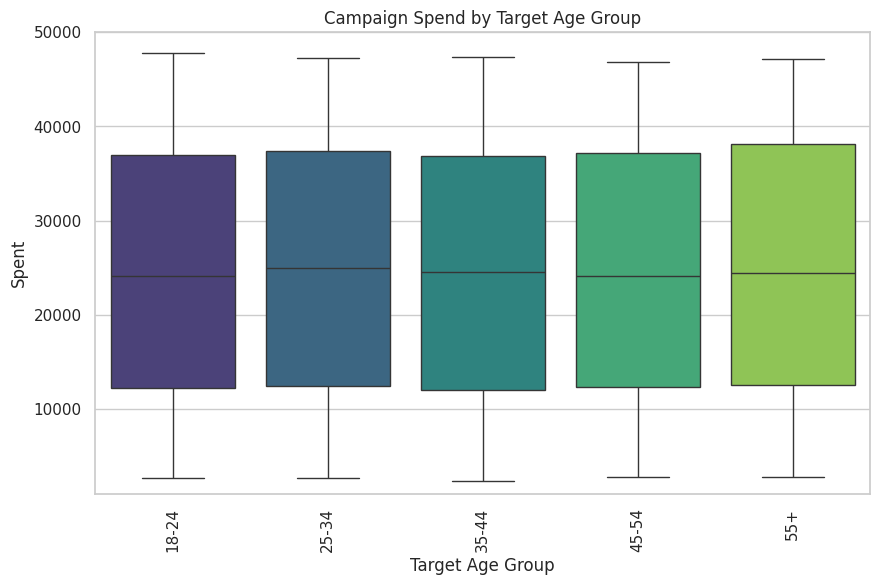

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="age_group", y="cmp_spent",hue = "age_group", palette="viridis", dodge=False, legend=False, whis=[5,95], showfliers=False)
plt.title("Campaign Spend by Target Age Group")
plt.xlabel("Target Age Group")
plt.ylabel("Spent")
plt.xticks(rotation=90)
plt.ylim(1000,50000)
plt.show()

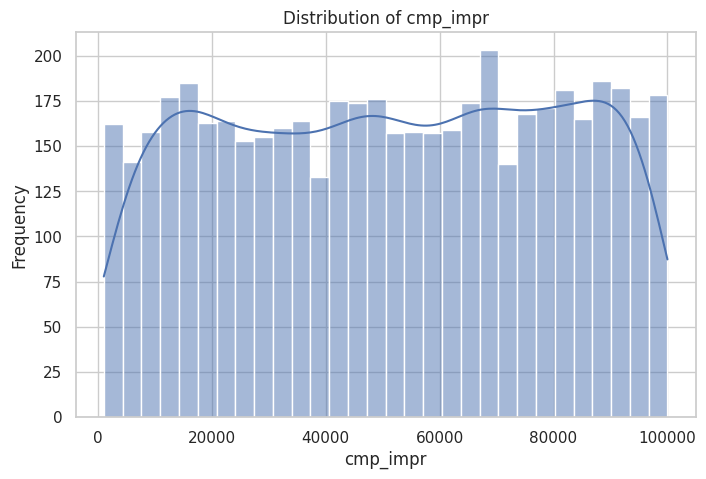

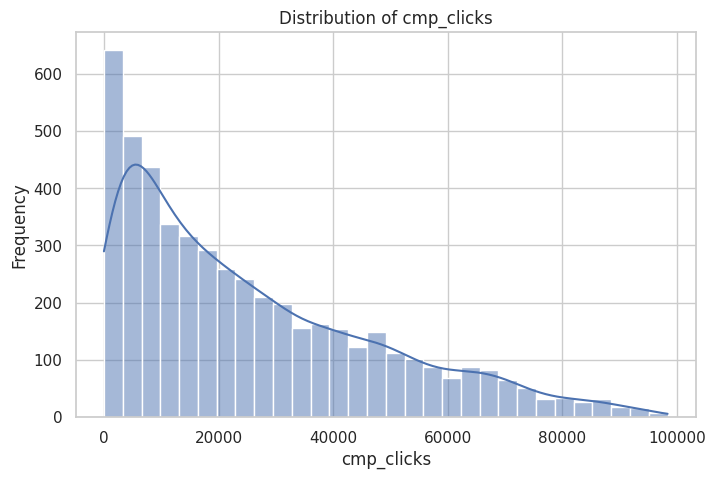

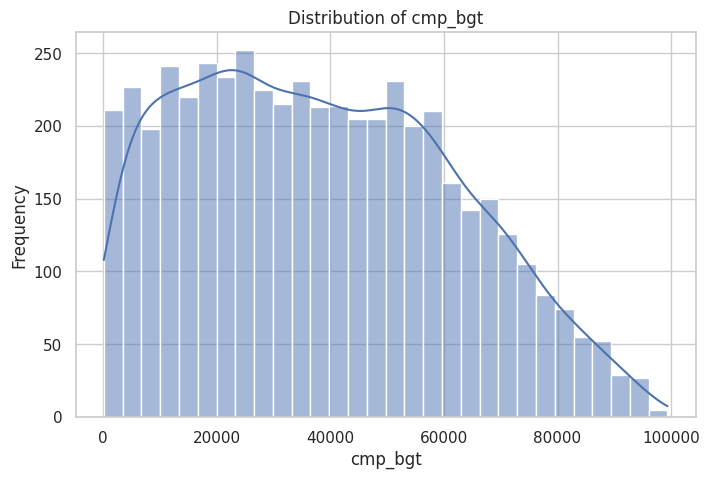

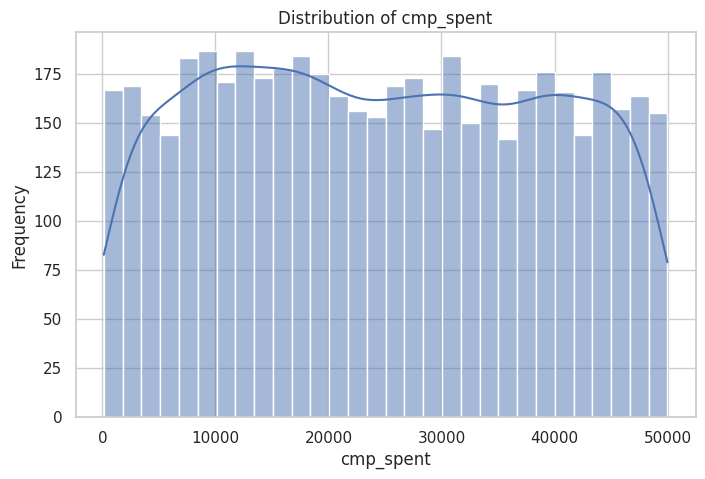

In [15]:
# Define a list of campaign metrics to visualize
metrics = ["cmp_impr", "cmp_clicks", "cmp_bgt", "cmp_spent"]

# Loop through each metric to generate its distribution plot
for metric in metrics:
    plt.figure(figsize=(8, 5)) # Set the figure size for consistent formatting

    # Create a histogram with a Kernel Density Estimate line
    # This shows both the frequency of values and the smoothed distribution
    sns.histplot(df[metric], bins=30, kde=True)

    plt.title(f"Distribution of {metric}") # Set plot title based on the current metric
    plt.xlabel(metric) # label the X-axis with the metric name
    plt.ylabel("Frequency") # Label the Y-axis to show the count of values per bin
    plt.show()

In [16]:
df.rename(columns={
    "cmp_impr": "Impressions",
    "cmp_clicks": "Clicks",
    "cmp_spent": "Spent",
    "Age": "Target Age",
    "Gender": "Target Gender"
}, inplace=True)

pivot = df.pivot_table(
    values=["Impressions", "Clicks", "Spent"],
    index="Target Age",
    columns="Target Gender",
    aggfunc=np.sum,
    fill_value=0  # Fills NaN with 0 for missing combinations
)

pivot

<ipython-input-16-ea99c1f8c7aa>:9: FutureWarning: The provided callable <function sum at 0x7ef448c2ccc0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot = df.pivot_table(


Clicks          Impressions                Spent            
Target Gender        F        M           F        M           F           M
Target Age                                                                  
18-25          1130890   762098     2206450  1737884  1213755.68   797946.63
18-30          1505783   673182     2892619  1310152  1440482.08   682441.40
18-35          1536084  1227118     3060260  2435858  1208312.04   889268.73
18-40          1384430   731430     2850153  1636585  1548081.31   868721.32
18-45          1556915   886670     2847052  1909386  1334378.88  1048303.89
18-50          1112795   975633     2410806  1674431  1156229.80   984705.70
18-55          1955752   709114     3434721  1240318  1690274.55   448719.70
18-60          1566177   669405     2871254  1449082  1386393.71   799179.56
23-25          1639287   884465     3067045  2084152  1451276.18   917310.90
23-30          1328386   681256     2669287  1190626  1161959.94   517759.94
23-35          1370671   571153     2538784  1413645   997576.52   689404.21
23-40          1382836  1316613     2778205  2649364  1218050.80  1036632.56
23-45          1621548   743724     3313256  1367473  1433201.87   632042.68
23-50          1106553   801040     2531111  1877354  1065002.72   925705.34
23-55          1606952   863990     3102161  1754861  1483856.99   857075.74
23-60          1103657   844063     2292311  1587247  1110064.43   694204.86
28-25          1718955  1232653     3319664  2429791  1556156.09  1024860.69
28-30          1192286   852139     2774118  1529348  1331833.02   813992.30
28-35           902919  1125386     2087396  2034891  1209599.41  1096115.12
28-40          1652628   825309     3590277  1765038  1657076.20   928641.14
28-45          1383978  1331499     2736549  2493338  1124736.47  1126393.53
28-50          1239498   740347     2553252  1503082  1429364.18   663717.38
28-55          1241867  1188484     2696650  2336145  1310128.73  1028616.36
28-60          1065002   622167     2119631  1452385  1138170.57   581394.64
33-25          1387920  1285492     2711862  2099266  1199688.42  1029072.99
33-30          1065732   790041     2313452  1516847  1230086.08   620970.94
33-35          1252448  1232384     2499230  2420401  1347930.83  1182932.45
33-40          1737684   655992     2849374  1564982  1357966.10   755426.88
33-45          1635760   696313     2961768  1566446  1438339.52   758457.11
33-50          1674675   772453     3225022  1714752  1404527.97   824605.57
33-55          1435053   691752     2575188  1570027  1552245.27   800948.40
33-60          1051325  1162307     1699010  2257825   873952.43   832125.77
38-25          1433754   859759     2928590  1739310  1429513.40   931945.57
38-30          1116540   694485     2282779  1627942  1310329.88   804989.86
38-35          1771703  1179486     3188917  1945020  1459245.30   908607.19
38-40          1447783   763782     2617625  1550947  1414830.05   772540.09
38-45          1456615   946806     2824598  1844016  1343830.58   873917.80
38-50          1341016  1233594     2786467  2198580  1396580.39  1010538.13
38-55           926537   809497     1714889  1595679   928546.07   978652.17
38-60          1246607   916091     2121307  2006573   969561.51  1046539.11
43-25          1655398   969115     3145918  2132861  1458798.74   958704.30
43-30          1544074   879934     2985117  1684830  1342641.18   831615.76
43-35          1345963  1151410     2993477  2566911  1626859.02  1407797.07
43-40           854304  1131098     2331829  2460008  1005193.53   990801.74
43-45          1391686   973309     2629379  1878124  1289733.32  1072048.38
43-50          1536700   994337     3264721  1688917  1480035.69   718453.65
43-55          1345180   760088     2693633  1749032  1433808.41   751793.33
43-60          1239091   894889     2479267  1937425  1299098.95  1007163.31
48-25          1471430   926551     3216279  1722651  1458662.98   806672.25
48-30       